In [1]:
from helpers import *
from implementations import *
from preprocessing import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
data_folder = './data/'
#data_folder = 'C:/Users/ACER/OneDrive - epfl.ch/Desktop/ML/dataset/'
#data_folder = "C:/Users/plane/OneDrive/Bureau/MilaLyon/data/dataset/"

# Loading data from CSV files

The file `data/default_values.csv` contains information about each feature

* **feature**: name of the feature

* **Value for zero**: value to replace missing values if the feature is numerical and the missing values are to be replaced by zero (ex: for `CHILDREN` 88 means 0 children)

* **Combination of other indicators**: 1 if the feature is just a combination of other features (ex: `_RFHLTH` is 1 if `GENHLTH` = 1, 2 or 3 and 2 if `GENHLTH` = 4 or 5)

* **Health related**: 1 if the feature is health related

* **Bad format, better format elsewhere**: 1 if the feature is in a bad format but parsed in another feature

* **Bad format, no better**: 1 if the feature is in a bad format and not parsed in another feature

* **Values for no response**: values that indicate no response

In [3]:
_data = load_csv_data(data_folder, max_rows=50000)
x_train, x_test, y_train, train_ids, test_ids, feature_names, zero_values, default_values, useless, health_related, better_elsewhere, bad_format_no_better = _data

print("Number of training samples: ", x_train.shape[0]
      , "\nNumber of test samples: ", x_test.shape[0]
      , "\nNumber of features: ", x_train.shape[1])

Number of training samples:  50000 
Number of test samples:  50000 
Number of features:  321


In [4]:
# Pandas version
# drop first column (ids)
df_x_train = pd.read_csv(data_folder + 'x_train.csv').drop(columns=['Id'])
df_y_train = pd.read_csv(data_folder + 'y_train.csv').drop(columns=['Id'])
df_x_test = pd.read_csv(data_folder + 'x_test.csv').drop(columns=['Id'])

# Pandas version
print(df_x_train.info())
print(df_x_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 328135 entries, 0 to 328134
Columns: 321 entries, _STATE to _AIDTST3
dtypes: float64(244), int64(77)
memory usage: 803.6 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109379 entries, 0 to 109378
Columns: 321 entries, _STATE to _AIDTST3
dtypes: float64(237), int64(84)
memory usage: 267.9 MB
None


# Preprocessing

## Replace some values by zero

In [5]:
replace_by_zero(x_train, x_test, zero_values)

In [6]:
# With Pandas
for feature in feature_names:
    df_x_train.loc[df_x_train[feature] == zero_values[feature], feature] = 0
    df_x_test.loc[df_x_test[feature] == zero_values[feature], feature] = 0
    
    if zero_values[feature] != None and np.isnan(zero_values[feature]):
        df_x_train[feature] = df_x_train[feature].fillna(0)
        df_x_test[feature] = df_x_test[feature].fillna(0)

## Replace default values in dataset by NaN

Custom implementation

In [7]:
print("Default values for _PRACE1:", default_values['_PRACE1'])

print()
print("Row index | Value of _PRACE1 before replacing defaults with NaN")
print("9         |", x_train[9,feature_names == '_PRACE1'])
print("101       |", x_train[101,feature_names == '_PRACE1'])
print("202       |", x_train[202,feature_names == '_PRACE1'])

replace_default_with_nan(x_train, x_test, feature_names, default_values)

print()
print("Row index | Value of _PRACE1 after replacing defaults with NaN")
print("9         |", x_train[9,feature_names == '_PRACE1'])
print("101       |", x_train[101,feature_names == '_PRACE1'])
print("202       |", x_train[202,feature_names == '_PRACE1'])

Default values for _PRACE1: [77.0, 99.0]

Row index | Value of _PRACE1 before replacing defaults with NaN
9         | [77.]
101       | [6.]
202       | [99.]

Row index | Value of _PRACE1 after replacing defaults with NaN
9         | [nan]
101       | [6.]
202       | [nan]


Pandas implementation

In [8]:
# With Pandas
print()
print("Row index | Value of _PRACE1 before replacing defaults with NaN")
print("9         |", df_x_train.loc[9,'_PRACE1'])
print("101       |", df_x_train.loc[101,'_PRACE1'])
print("202       |", df_x_train.loc[202,'_PRACE1'])

for feature in feature_names:
    # Replace default values with NaN
    for default_value in default_values[feature]:
        df_x_train.loc[df_x_train[feature] == default_value, feature] = np.nan
        df_x_test.loc[df_x_test[feature] == default_value, feature] = np.nan
        
print()
print("Row index | Value of _PRACE1 after replacing defaults with NaN")
print("9         |", df_x_train.loc[9,'_PRACE1'])
print("101       |", df_x_train.loc[101,'_PRACE1'])
print("202       |", df_x_train.loc[202,'_PRACE1'])


Row index | Value of _PRACE1 before replacing defaults with NaN
9         | 77
101       | 6
202       | 99

Row index | Value of _PRACE1 after replacing defaults with NaN
9         | nan
101       | 6.0
202       | nan


## Identify features type (binary, categorical, continuous)

In [9]:
feature_types = detect_feature_type(x_train)

for i, feature in enumerate(feature_names):
    print(f"{i}: {feature} - {feature_types[i]}", end="")
    if useless[i]:
        print(" (useless)", end="")
    if health_related[i]:
        print(" (health related)", end="")
    if better_elsewhere[i]:
        print(" (better elsewhere)", end="")
    if bad_format_no_better[i]:
        print(" (bad format, no better)", end="")
    if zero_values[feature] != None:
        print(" (zero value:", zero_values[feature], end=")")
    if len(default_values[feature]) > 0:
        print(" (default values:", default_values[feature], end=")")
    print()

0: _STATE - continuous
1: FMONTH - continuous
2: IDATE - continuous (better elsewhere)
3: IMONTH - continuous
4: IDAY - continuous
5: IYEAR - binary
6: DISPCODE - binary
7: SEQNO - continuous
8: _PSU - continuous
9: CTELENUM - binary (zero value: nan)
10: PVTRESD1 - binary
11: COLGHOUS - binary (zero value: nan)
12: STATERES - binary (zero value: nan)
13: CELLFON3 - binary
14: LADULT - binary
15: NUMADULT - categorical
16: NUMMEN - categorical
17: NUMWOMEN - categorical
18: CTELNUM1 - binary (zero value: nan)
19: CELLFON2 - binary (zero value: nan)
20: CADULT - binary
21: PVTRESD2 - binary
22: CCLGHOUS - binary (zero value: nan)
23: CSTATE - binary
24: LANDLINE - binary (default values: [7.0, 9.0])
25: HHADULT - continuous (default values: [77.0, 99.0])
26: GENHLTH - categorical (health related) (default values: [7.0, 9.0])
27: PHYSHLTH - continuous (health related) (zero value: 88.0) (default values: [77.0, 99.0])
28: MENTHLTH - continuous (health related) (zero value: 88.0) (default 

## Plot the number of missing values per feature

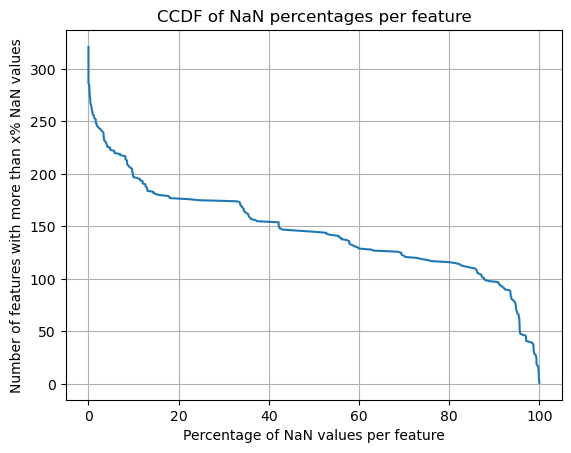

In [10]:
# Percentage of NaN values per feature
nan_percentage = np.mean(np.isnan(x_train), axis=0) * 100
# Cummulative distribution function of NaN percentages
sorted_nan_percentage = np.sort(nan_percentage)
plt.plot(sorted_nan_percentage, np.arange(len(sorted_nan_percentage), 0, -1))
plt.xlabel('Percentage of NaN values per feature')
plt.ylabel('Number of features with more than x% NaN values')
plt.title('CCDF of NaN percentages per feature')
plt.grid()
plt.show()

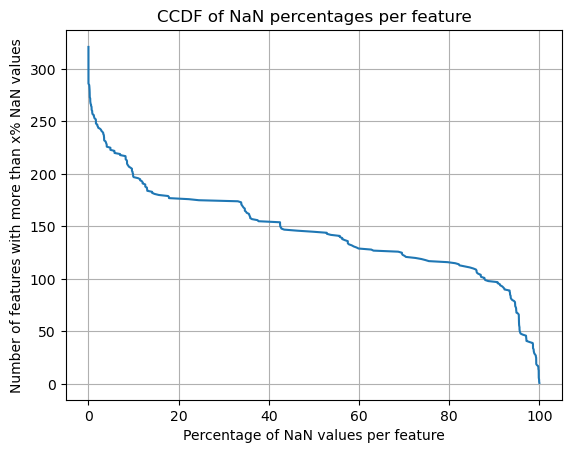

In [11]:
# Pandas version
# Plot ccdf of NaN percentages
nan_percentage = df_x_train.isna().mean() * 100
sorted_nan_percentage = np.sort(nan_percentage)
plt.plot(sorted_nan_percentage, np.arange(len(sorted_nan_percentage), 0, -1))
plt.xlabel('Percentage of NaN values per feature')
plt.ylabel('Number of features with more than x% NaN values')
plt.title('CCDF of NaN percentages per feature')
plt.grid()
plt.show()


# Normalize features

In [12]:
x_train_normalized, x_test_normalized = normalize(x_train, x_test)

In [13]:
# With Pandas
df_x_train_normalized = (df_x_train - df_x_train.mean()) / df_x_train.std()
df_x_test_normalized = (df_x_test - df_x_train.mean()) / df_x_train.std()

## Replace missing values by the mean of the feature

In [14]:
# Since we normalized the data, the mean should be 0
x_train_normalized[np.where(np.isnan(x_train_normalized))] = 1
x_test_normalized[np.where(np.isnan(x_test_normalized))] = 0

# If the data is not normalized :
# mean_imputation(x_train, x_test)

In [15]:
# With Pandas
df_x_train_normalized.fillna(0, inplace=True)
df_x_test_normalized.fillna(0, inplace=True)

## Add bias term

In [16]:
const_train = np.ones((x_train_normalized.shape[0], 1))
const_test = np.ones((x_test_normalized.shape[0], 1))
tx_train_normalized = np.hstack((x_train_normalized, const_train))
tx_test_normalized = np.hstack((x_test_normalized, const_test))

In [17]:
df_tx_train_normalized = df_x_train_normalized.copy()
df_tx_train_normalized['_CONST'] = 1
df_tx_test_normalized = df_x_test_normalized.copy()
df_tx_test_normalized['_CONST'] = 1

# Correlation between features

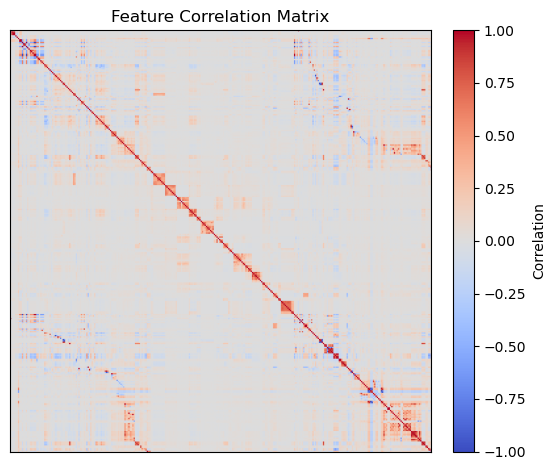

In [18]:
# Compute correlation matrix (each row is an observation, each column a feature)
corr = np.corrcoef(x_train_normalized, rowvar=False)

# Plot heatmap
im = plt.imshow(corr, cmap="coolwarm", vmin=-1, vmax=1)
plt.colorbar(im, fraction=0.046, pad=0.04, label="Correlation")
plt.xticks([])
plt.yticks([])
plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.show()

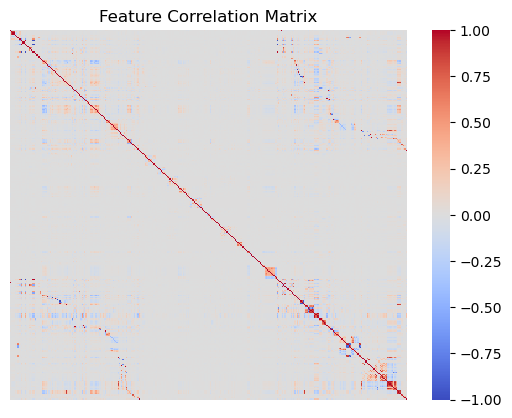

In [19]:
# Pandas version
# Compute correlation matrix (rows=features)
corr_pd = df_x_train_normalized.corr()
# Plot heatmap without axis ticks
sns.heatmap(corr_pd, cmap="coolwarm", vmin=-1, vmax=1, xticklabels=False, yticklabels=False)
plt.title("Feature Correlation Matrix")
plt.show()

In [20]:
# Optionally print highly correlated pairs
threshold = 0.9
print(f"\nHighly correlated features (|corr| > {threshold}):")
for i in range(corr.shape[0]):
    for j in range(i + 1, corr.shape[1]):
        if abs(corr[i, j]) > threshold:
            print(f"  {feature_names[i]} ↔ {feature_names[j]} : {corr[i, j]:.2f}")


Highly correlated features (|corr| > 0.9):
  _STATE ↔ _STSTR : 1.00
  IDATE ↔ IMONTH : 1.00
  SEQNO ↔ _PSU : 1.00
  CTELENUM ↔ STATERES : 1.00
  CTELENUM ↔ CTELNUM1 : -1.00
  CTELENUM ↔ CELLFON2 : -1.00
  CTELENUM ↔ QSTVER : -0.99
  STATERES ↔ CTELNUM1 : -1.00
  STATERES ↔ CELLFON2 : -1.00
  STATERES ↔ QSTVER : -0.99
  CTELNUM1 ↔ CELLFON2 : 1.00
  CTELNUM1 ↔ QSTVER : 0.99
  CELLFON2 ↔ QSTVER : 0.99
  BPHIGH4 ↔ _RFHYPE5 : -0.99
  BLOODCHO ↔ _CHOLCHK : 0.95
  ASTHMA3 ↔ _LTASTH1 : -0.99
  ASTHMA3 ↔ _ASTHMS1 : 0.93
  ASTHNOW ↔ _CASTHM1 : -0.98
  HAVARTH3 ↔ _DRDXAR1 : 1.00
  EDUCA ↔ _EDUCAG : 0.99
  CHILDREN ↔ _CHLDCNT : 0.95
  INCOME2 ↔ _INCOMG : 0.98
  SMOKDAY2 ↔ _SMOKER3 : 0.95
  SMOKDAY2 ↔ _RFSMOK3 : -0.91
  ALCDAY5 ↔ DRNKANY5 : 1.00
  EXERANY2 ↔ _TOTINDA : 1.00
  EXERHMM1 ↔ PADUR1_ : 1.00
  EXERHMM2 ↔ PADUR2_ : 1.00
  ARTHSOCL ↔ _LMTSCL1 : 0.93
  HIVTST6 ↔ _AIDTST3 : 1.00
  _STRWT ↔ _WT2RAKE : 0.95
  _CRACE1 ↔ _CPRACE : 1.00
  _LTASTH1 ↔ _ASTHMS1 : -0.93
  _CASTHM1 ↔ _ASTHMS1 : -0.93


## Correlation between features and target

In [21]:
np.unique(x_train_normalized[:, feature_names == '_FRT16'], return_counts=True)

(array([-6.74125696e+01,  1.48340288e-02]), array([   11, 49989]))

In [22]:
corr_with_target = np.array([np.corrcoef(x_train_normalized[:, i], y_train)[0, 1] for i in range(x_train_normalized.shape[1])])
correlation_ranked = np.argsort(np.abs(corr_with_target))[::-1]

excluded_features = []

for idx in correlation_ranked:
    if not np.isnan(corr_with_target[idx]):
        print(f"{feature_names[idx]}: {corr_with_target[idx]:.4f}")
    else:
        excluded_features.append(feature_names[idx])
print("\nExcluded features due to NaN correlation with target:", excluded_features)

GENHLTH: 0.2498
_RFHLTH: 0.2405
_AGE80: 0.2253
_AGEG5YR: 0.2244
_RFHYPE5: 0.2126
EMPLOY1: 0.2115
DIFFWALK: -0.2111
BPHIGH4: -0.2103
_AGE_G: 0.2062
_AGE65YR: 0.2042
CVDSTRK3: -0.2031
BPMEDS: -0.1954
TOLDHI2: -0.1938
USEEQUIP: -0.1924
PHYSHLTH: 0.1918
QLACTLM2: -0.1862
_LMTSCL1: -0.1749
DIABETE3: -0.1730
PNEUVAC3: -0.1720
CHCCOPD1: -0.1692
_PNEUMO2: -0.1686
_DRDXAR1: -0.1683
HAVARTH3: -0.1683
ARTHSOCL: -0.1681
_LMTACT1: -0.1679
LMTJOIN3: -0.1544
INTERNET: 0.1519
_LMTWRK1: -0.1508
DIFFALON: -0.1453
_FLSHOT6: -0.1436
_RFCHOL: 0.1361
CHCKIDNY: -0.1348
ARTHDIS2: -0.1318
CHOLCHK: -0.1210
VETERAN3: -0.1210
DIABEYE: -0.1186
DIFFDRES: -0.1145
SMOKE100: -0.1109
INSULIN: -0.1097
HAREHAB1: -0.1073
ACTIN11_: 0.1061
BLIND: -0.1050
PERSDOC2: 0.1043
DECIDE: -0.1035
_CHLDCNT: -0.1015
CIMEMLOS: -0.1011
DIABAGE2: -0.0992
BLDSUGAR: -0.0971
_CHOLCHK: -0.0969
INCOME2: -0.0963
_HCVU651: 0.0953
_INCOMG: -0.0944
CHILDREN: -0.0941
EYEEXAM: -0.0927
CDASSIST: -0.0920
DIABEDU: -0.0917
FEETCHK2: -0.0901
BLOODCHO: -0

In [23]:
# Pandas version
corr_with_target_pd = df_x_train_normalized.corrwith(df_y_train['_MICHD'])
correlation_ranked_pd = corr_with_target_pd.abs().sort_values(ascending=False)

excluded_features = []

for feature, corr_value in correlation_ranked_pd.items():
    if np.isnan(corr_value):
        excluded_features.append(feature)
    else:
        print(f"{feature}: {corr_value:.4f}")
        
print("\nExcluded features due to NaN correlation with target:", excluded_features)
    

GENHLTH: 0.2488
_RFHLTH: 0.2348
_AGEG5YR: 0.2258
_AGE80: 0.2245
_RFHYPE5: 0.2172
BPHIGH4: 0.2143
DIFFWALK: 0.2128
EMPLOY1: 0.2111
_AGE_G: 0.2069
CVDSTRK3: 0.2060
_AGE65YR: 0.2028
USEEQUIP: 0.1906
CHCCOPD1: 0.1858
QLACTLM2: 0.1846
PHYSHLTH: 0.1818
_LMTSCL1: 0.1810
_LMTACT1: 0.1754
_RFCHOL: 0.1750
TOLDHI2: 0.1750
PNEUVAC3: 0.1707
_DRDXAR1: 0.1678
HAVARTH3: 0.1678
DIABETE3: 0.1674
_LMTWRK1: 0.1636
INTERNET: 0.1477
DIFFALON: 0.1379
CHCKIDNY: 0.1340
POORHLTH: 0.1247
VETERAN3: 0.1197
DIFFDRES: 0.1162
INCOME2: 0.1091
_INCOMG: 0.1084
SMOKE100: 0.1070
_CHLDCNT: 0.1046
BLIND: 0.1035
CHILDREN: 0.1011
PERSDOC2: 0.0979
DECIDE: 0.0976
CHOLCHK: 0.0972
_CHOLCHK: 0.0935
DRNKANY5: 0.0871
ALCDAY5: 0.0867
EDUCA: 0.0859
BPMEDS: 0.0858
BLOODCHO: 0.0855
_EDUCAG: 0.0847
CHCOCNCR: 0.0846
CHCSCNCR: 0.0840
ACTIN11_: 0.0827
ARTHSOCL: 0.0822
JOINPAIN: 0.0795
QSTVER: 0.0792
STATERES: 0.0787
CTELNUM1: 0.0786
CTELENUM: 0.0786
CELLFON2: 0.0786
EXERANY2: 0.0779
_TOTINDA: 0.0779
SEX: 0.0709
DRADVISE: 0.0702
FLUSHOT6: 0.

# Principal Component Analysis (PCA)

Keeping 134 components explaining 95.04% variance


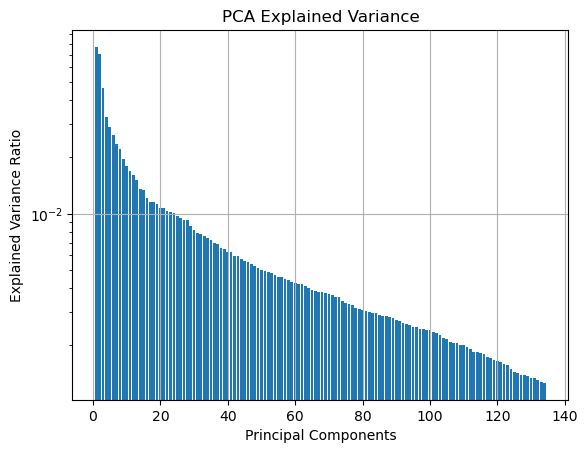

In [24]:
x_train_pca, eigvecs, explained_variance = pca_reduce(x_train_normalized, variance_threshold=0.95)

plt.bar(np.arange(1, len(explained_variance) + 1), explained_variance)
plt.yscale('log')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('PCA Explained Variance')
plt.grid()
plt.show()

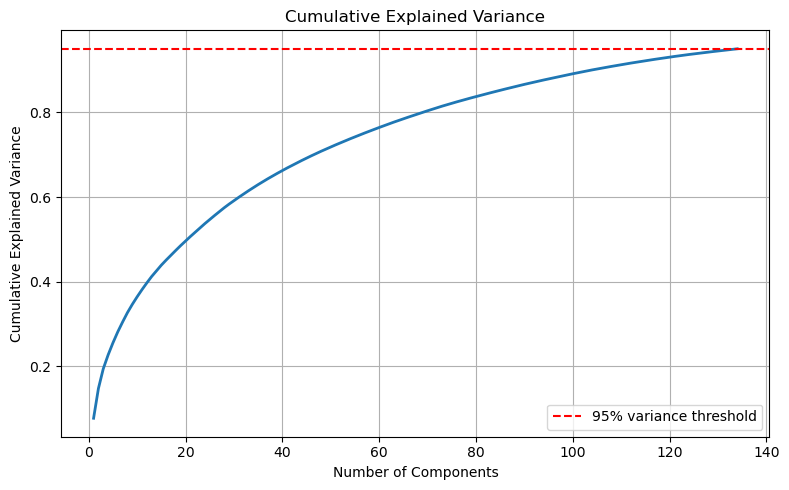

In [25]:
cumulative_variance = np.cumsum(explained_variance)

plt.figure(figsize=(8, 5))
plt.plot(np.arange(1, len(cumulative_variance) + 1), cumulative_variance, '-', linewidth=2)
plt.axhline(y=0.95, color='r', linestyle='--', label='95% variance threshold')
plt.title("Cumulative Explained Variance")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


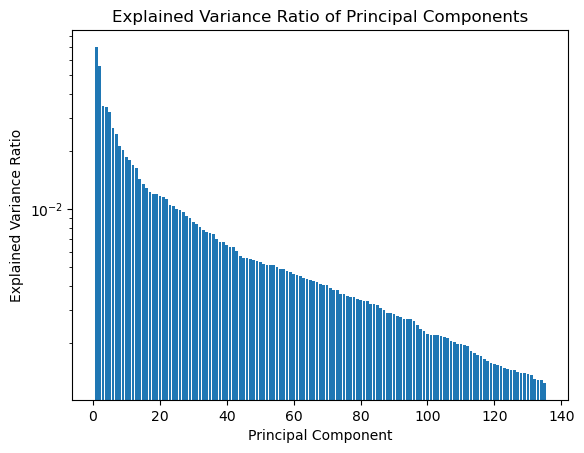

In [26]:
# using pandas and sklearn
from sklearn.decomposition import PCA
pca = PCA(n_components=135)
pca.fit_transform(df_x_train_normalized.fillna(df_x_train.mean()))

# Plot the explained variance ratio, y log scale
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_)
plt.yscale('log')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio of Principal Components')
plt.show()

# Logistic Regression

Still in progress...

In [29]:
y_train_bin = (y_train == 1).astype(int)

max_iters = 2000      # number of gradient descent steps
gamma = 0.005       # learning rate

initial_w = np.zeros(tx_train_normalized.shape[1])
w, loss = logistic_regression(y_train, tx_train_normalized, initial_w, max_iters, gamma)
print(f"Final training loss: {loss:.4f}")

Final training loss: -843.3305


In [34]:
def predict_labels(tx, w, threshold=0.5):
    pred = sigmoid(tx @ w)
    return 2*(pred >= threshold).astype(int) - 1

In [37]:
y_pred_train = predict_labels(tx_train_normalized, w)

acc_train = np.mean(y_train == y_pred_train)
print(f"Training accuracy: {acc_train*100:.2f}%")

Training accuracy: 91.34%


In [38]:
# Predict on test set and save predictions
y_pred_test = predict_labels(df_tx_test_normalized.to_numpy(), w)
create_csv_submission(np.arange(test_ids[0], test_ids[0] + len(y_pred_test)), y_pred_test, 'logistic_regression_submission.csv')

In [39]:
# Logistic regression with sklearn
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000)
model.fit(df_tx_train_normalized, df_y_train.values.ravel())

# percentage of correct predictions
y_pred_train = model.predict(df_tx_train_normalized)
accuracy = np.mean(y_pred_train == df_y_train.values.ravel())
print(f"Training accuracy: {accuracy*100:.2f}%")

Training accuracy: 91.49%


In [40]:
# Neural Network with sklearn
from sklearn.neural_network import MLPClassifier
model = MLPClassifier(hidden_layer_sizes=(10, 10), max_iter=1000)
model.fit(df_tx_train_normalized, df_y_train.values.ravel())

# Performance on training set
y_pred_train = model.predict(df_tx_train_normalized)
accuracy = np.mean(y_pred_train == df_y_train.values.ravel())
print(f"Training accuracy: {accuracy*100:.2f}%")

Training accuracy: 91.93%


In [ ]:
# SVM with kernel
from sklearn.svm import SVC
model = SVC(kernel='rbf', C=1.0, gamma='scale')
model.fit(df_tx_train_normalized, df_y_train.values.ravel())
# Performance on training set
y_pred_train = model.predict(df_tx_train_normalized)
accuracy = np.mean(y_pred_train == df_y_train.values.ravel())
print(f"Training accuracy: {accuracy*100:.2f}%")

In [ ]:
# predict on test set
y_pred_test = model.predict(df_tx_test_normalized)
create_csv_submission(np.arange(test_ids[0], test_ids[0] + len(y_pred_test)), y_pred_test, 'logistic_regression_sklearn_submission.csv')